#  Experiments with surface heat flux looking at polar amplification

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab import constants as const

##  EBM with surface and atm layers

In [2]:
ebm = climlab.GreyRadiationModel(num_lev=1, num_lat=90)
insolation = climlab.radiation.insolation.AnnualMeanInsolation(domains=ebm.Ts.domain)
ebm.add_subprocess('insolation', insolation)
print ebm

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (90, 1) 
  Ts: (90, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>



In [3]:
#  add a fixed relative humidity process
#  (will only affect surface evaporation)
q = np.zeros_like(ebm.Tatm)
ebm.set_state('q', q)
h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=ebm.state, **ebm.param)
ebm.add_subprocess('H2O', h2o)

In [4]:
#  Add surface heat fluxes
from climlab.surface.turbulent import SensibleHeatFlux, LatentHeatFlux
shf = SensibleHeatFlux(state=ebm.state, Cd=3E-4)
lhf = LatentHeatFlux(state=ebm.state, Cd=3E-4)
ebm.add_subprocess('SHF', shf)
ebm.add_subprocess('LHF', lhf)

In [5]:
ebm.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.999336878378 years.


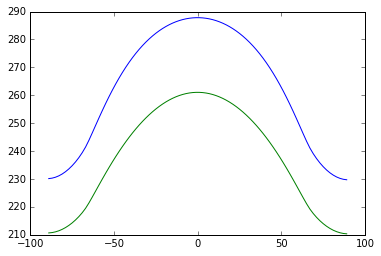

In [6]:
plt.plot(ebm.lat, ebm.Ts)
plt.plot(ebm.lat, ebm.Tatm)

In [7]:
co2ebm = climlab.process_like(ebm)
co2ebm.subprocess['LW'].absorptivity = ebm.subprocess['LW'].absorptivity*1.1

In [8]:
co2ebm.integrate_years(3.)

Integrating for 1095 steps, 1095.7266 days, or 3.0 years.
Total elapsed time is 3.99734751351 years.


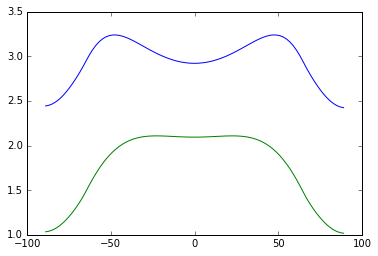

In [9]:
#  no heat transport but with evaporation -- no polar amplification
plt.plot(ebm.lat, co2ebm.Ts - ebm.Ts)
plt.plot(ebm.lat, co2ebm.Tatm - ebm.Tatm)

### Now with meridional heat transport

In [10]:
diffebm = climlab.process_like(ebm)
# thermal diffusivity in W/m**2/degC
D = 0.6
# meridional diffusivity in 1/s
K = D / diffebm.Tatm.domain.heat_capacity
d = climlab.dynamics.diffusion.MeridionalDiffusion(K=K, state={'Tatm': diffebm.state['Tatm']}, **diffebm.param)
diffebm.add_subprocess('diffusion', d)
print diffebm

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (90, 1) 
  q: (90, 1) 
  Ts: (90, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   diffusion: <class 'climlab.dynamics.diffusion.MeridionalDiffusion'>
   LHF: <class 'climlab.surface.turbulent.LatentHeatFlux'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   H2O: <class 'climlab.radiation.water_vapor.FixedRelativeHumidity'>
   SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>



In [11]:
diffebm.integrate_years(3)

Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 3.99734751351 years.


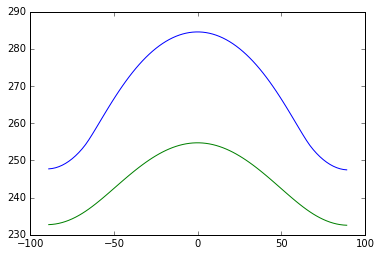

In [12]:
plt.plot(diffebm.lat, diffebm.Ts)
plt.plot(diffebm.lat, diffebm.Tatm)

In [13]:
def inferred_heat_transport( energy_in, lat_deg ):
    '''Returns the inferred heat transport (in PW) by integrating the net energy imbalance from pole to pole.'''
    from scipy import integrate
    from climlab import constants as const
    lat_rad = np.deg2rad( lat_deg )
    return ( 1E-15 * 2 * np.math.pi * const.a**2 * integrate.cumtrapz( np.cos(lat_rad)*energy_in,
            x=lat_rad, initial=0. ) )

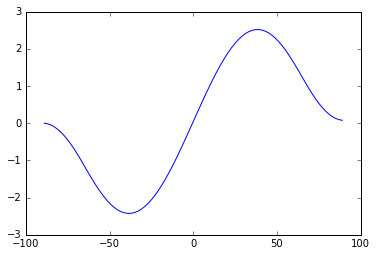

In [14]:
#  Plot the northward heat transport in this model
Rtoa = np.squeeze(diffebm.timeave['ASR'] - diffebm.timeave['OLR'])
plt.plot(diffebm.lat, inferred_heat_transport(Rtoa, diffebm.lat))

In [15]:
##  Now warm it up!
co2diffebm = climlab.process_like(diffebm)
co2diffebm.subprocess['LW'].absorptivity = diffebm.subprocess['LW'].absorptivity*1.1

In [16]:
co2diffebm.integrate_years(5)

Integrating for 1826 steps, 1826.211 days, or 5 years.
Total elapsed time is 8.99676981466 years.


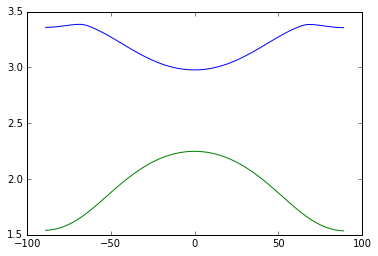

In [17]:
#  with heat transport and evaporation 
#   Get some modest polar amplifcation of surface warming
#    but larger equatorial amplification of atmospheric warming
#    Increased atmospheric gradient = increased poleward flux.
plt.plot(diffebm.lat, co2diffebm.Ts - diffebm.Ts)
plt.plot(diffebm.lat, co2diffebm.Tatm - diffebm.Tatm)

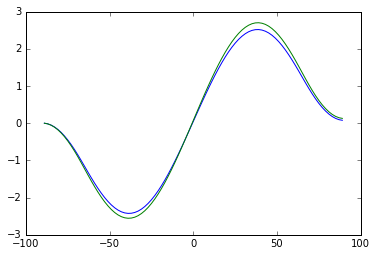

In [18]:
Rtoa = np.squeeze(diffebm.timeave['ASR'] - diffebm.timeave['OLR'])
Rtoa_co2 = np.squeeze(co2diffebm.timeave['ASR'] - co2diffebm.timeave['OLR'])
plt.plot(diffebm.lat, inferred_heat_transport(Rtoa, diffebm.lat))
plt.plot(diffebm.lat, inferred_heat_transport(Rtoa_co2, diffebm.lat))

## Same thing but with NO EVAPORATION

Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 6.99535814865 years.
Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 11.9947804498 years.


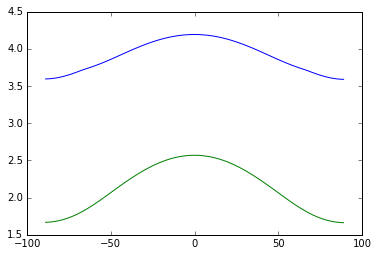

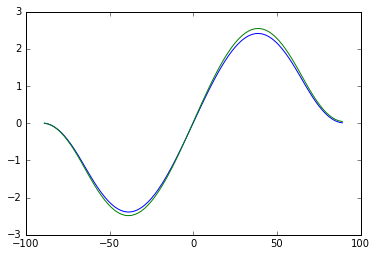

In [19]:
diffebm2 = climlab.process_like(diffebm)
diffebm2.remove_subprocess('LHF')
diffebm2.integrate_years(3)
co2diffebm2 = climlab.process_like(co2diffebm)
co2diffebm2.remove_subprocess('LHF')
co2diffebm2.integrate_years(3)
#  With transport and no evaporation...
#  No polar amplification, either of surface or air temperature!
plt.plot(diffebm2.lat, co2diffebm2.Ts - diffebm2.Ts)
plt.plot(diffebm2.lat, co2diffebm2.Tatm[:,0] - diffebm2.Tatm[:,0])
plt.figure()
#  And in this case, the lack of polar amplification is DESPITE an increase in the poleward heat transport.
Rtoa = np.squeeze(diffebm2.timeave['ASR'] - diffebm2.timeave['OLR'])
Rtoa_co2 = np.squeeze(co2diffebm2.timeave['ASR'] - co2diffebm2.timeave['OLR'])
plt.plot(diffebm2.lat, inferred_heat_transport(Rtoa, diffebm2.lat))
plt.plot(diffebm2.lat, inferred_heat_transport(Rtoa_co2, diffebm2.lat))

## A column model approach

In [20]:
model = climlab.GreyRadiationModel(num_lev=30, num_lat=90, abs_coeff=1.6E-4)
insolation = climlab.radiation.insolation.AnnualMeanInsolation(domains=model.Ts.domain)
model.add_subprocess('insolation', insolation)
print model

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (90, 30) 
  Ts: (90, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>



In [21]:
#  Convective adjustment for atmosphere only
conv = climlab.convection.convadj.ConvectiveAdjustment(state={'Tatm':model.state['Tatm']}, adj_lapse_rate=6.5,
                                                       **model.param)
model.add_subprocess('convective adjustment', conv)

In [22]:
#  add a fixed relative humidity process
#  (will only affect surface evaporation)
q = np.zeros_like(model.Tatm)
model.set_state('q', q)
h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=model.state, **model.param)
model.add_subprocess('H2O', h2o)

In [23]:
#  Add surface heat fluxes
from climlab.surface.turbulent import SensibleHeatFlux, LatentHeatFlux
shf = SensibleHeatFlux(state=model.state, Cd=1E-3)
lhf = LatentHeatFlux(state=model.state, Cd=1E-3)
model.add_subprocess('SHF', shf)
model.add_subprocess('LHF', lhf)

In [24]:
model.integrate_years(3.)

Integrating for 1095 steps, 1095.7266 days, or 3.0 years.
Total elapsed time is 2.99801063513 years.


In [25]:
def plot_temp_section(model, timeave=True):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if timeave:
        field = model.timeave['Tatm'].transpose()
    else:
        field = model.Tatm.transpose()
    cax = ax.contourf(model.lat, model.lev, field)
    ax.invert_yaxis()
    ax.set_xlim(-90,90)
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
    fig.colorbar(cax)

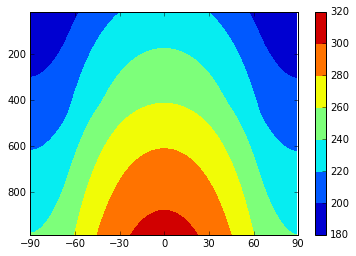

In [26]:
plot_temp_section(model, timeave=False)

In [27]:
co2model = climlab.process_like(model)
co2model.subprocess['LW'].absorptivity = model.subprocess['LW'].absorptivity*1.1

In [28]:
co2model.integrate_years(3)

Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 5.99602127027 years.


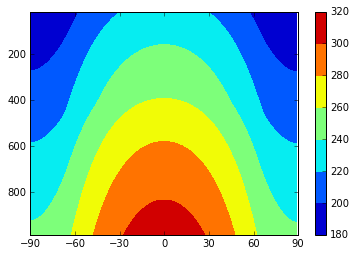

In [29]:
plot_temp_section(co2model, timeave=False)

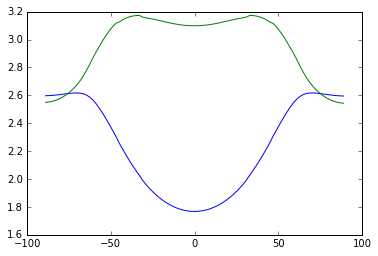

In [30]:
#  Without transport, get equatorial amplification
plt.plot(model.lat, co2model.Ts - model.Ts)
plt.plot(model.lat, co2model.Tatm[:,0] - model.Tatm[:,0])

##  Now with meridional heat tranpsort!

In [31]:
diffmodel = climlab.process_like(model)

In [32]:
# thermal diffusivity in W/m**2/degC
D = 0.05
# meridional diffusivity in 1/s
K = D / diffmodel.Tatm.domain.heat_capacity[0]
print K

1.46414342629e-07


In [33]:
d = climlab.dynamics.diffusion.MeridionalDiffusion(K=K, state={'Tatm':diffmodel.state['Tatm']}, **diffmodel.param)
diffmodel.add_subprocess('diffusion', d)
print diffmodel

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (90, 30) 
  q: (90, 30) 
  Ts: (90, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   diffusion: <class 'climlab.dynamics.diffusion.MeridionalDiffusion'>
   LHF: <class 'climlab.surface.turbulent.LatentHeatFlux'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   H2O: <class 'climlab.radiation.water_vapor.FixedRelativeHumidity'>
   SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>



In [34]:
diffmodel.integrate_years(3)

Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 5.99602127027 years.


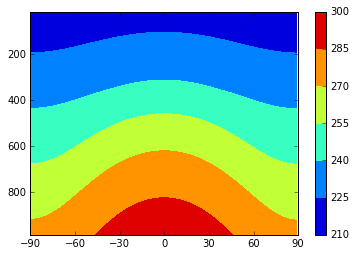

In [35]:
plot_temp_section(diffmodel)

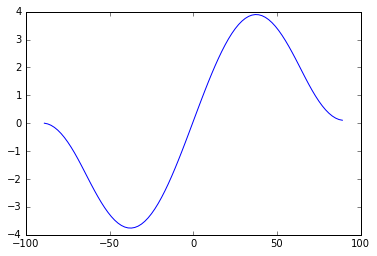

In [36]:
#  Plot the northward heat transport in this model
Rtoa = np.squeeze(diffmodel.timeave['ASR'] - diffmodel.timeave['OLR'])
plt.plot(diffmodel.lat, inferred_heat_transport(Rtoa, diffmodel.lat))

In [37]:
##  Now warm it up!
co2diffmodel = climlab.process_like(diffmodel)
co2diffmodel.subprocess['LW'].absorptivity = diffmodel.subprocess['LW'].absorptivity*1.1

In [38]:
co2diffmodel.integrate_years(3)

Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 8.9940319054 years.


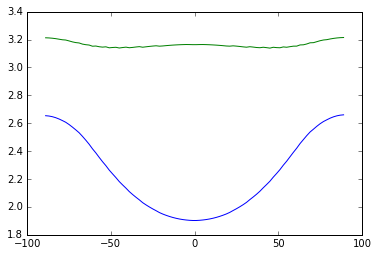

In [39]:
#  With transport, get polar amplification...
#   of surface temperature, but not of air temperature!
plt.plot(diffmodel.lat, co2diffmodel.Ts - diffmodel.Ts)
plt.plot(diffmodel.lat, co2diffmodel.Tatm[:,0] - diffmodel.Tatm[:,0])

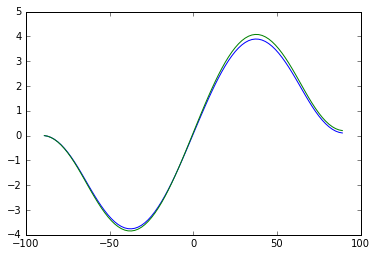

In [40]:
Rtoa = np.squeeze(diffmodel.timeave['ASR'] - diffmodel.timeave['OLR'])
Rtoa_co2 = np.squeeze(co2diffmodel.timeave['ASR'] - co2diffmodel.timeave['OLR'])
plt.plot(diffmodel.lat, inferred_heat_transport(Rtoa, diffmodel.lat))
plt.plot(diffmodel.lat, inferred_heat_transport(Rtoa_co2, diffmodel.lat))

## Same thing but with NO EVAPORATION


In [41]:
diffmodel2 = climlab.process_like(diffmodel)
diffmodel2.remove_subprocess('LHF')
print diffmodel2

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (90, 30) 
  q: (90, 30) 
  Ts: (90, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   diffusion: <class 'climlab.dynamics.diffusion.MeridionalDiffusion'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   H2O: <class 'climlab.radiation.water_vapor.FixedRelativeHumidity'>
   SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>



In [42]:
diffmodel2.integrate_years(3)

Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 8.9940319054 years.


In [43]:
co2diffmodel2 = climlab.process_like(co2diffmodel)
co2diffmodel2.remove_subprocess('LHF')
co2diffmodel2.integrate_years(3)

Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 11.9920425405 years.


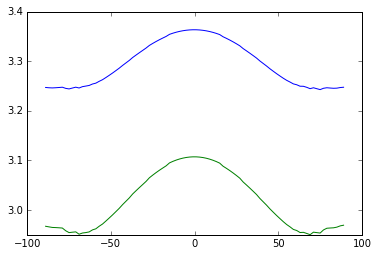

In [44]:
#  With transport and no evaporation...
#  No polar amplification, either of surface or air temperature!
plt.plot(diffmodel2.lat, co2diffmodel2.Ts - diffmodel2.Ts)
plt.plot(diffmodel2.lat, co2diffmodel2.Tatm[:,0] - diffmodel2.Tatm[:,0])

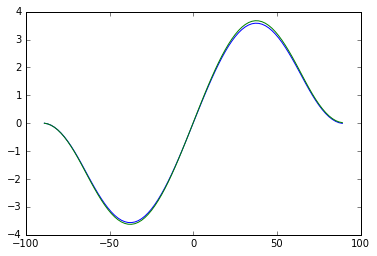

In [45]:
Rtoa = np.squeeze(diffmodel2.timeave['ASR'] - diffmodel2.timeave['OLR'])
Rtoa_co2 = np.squeeze(co2diffmodel2.timeave['ASR'] - co2diffmodel2.timeave['OLR'])
plt.plot(diffmodel2.lat, inferred_heat_transport(Rtoa, diffmodel2.lat))
plt.plot(diffmodel2.lat, inferred_heat_transport(Rtoa_co2, diffmodel2.lat))

## Warming effect of a DECREASE IN EVAPORATION EFFICIENCY

Take a column model that includes evaporation and heat transport, and reduce the drag coefficient by a factor of 2.

How does the surface temperature change?

In [46]:
diffmodel3 = climlab.process_like(diffmodel)
diffmodel3.subprocess['LHF'].Cd *= 0.5
diffmodel3.integrate_years(5.)

Integrating for 1826 steps, 1826.211 days, or 5.0 years.
Total elapsed time is 10.9954435714 years.


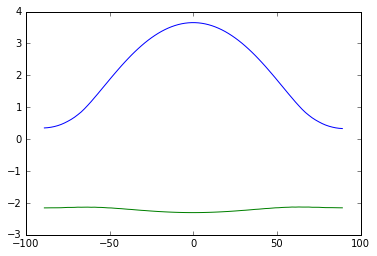

In [47]:
#  Reduced evaporation gives equatorially enhanced warming of surface
#  and cooling of near-surface air temperature
plt.plot(diffmodel.lat, diffmodel3.Ts - diffmodel.Ts)
plt.plot(diffmodel.lat, diffmodel3.Tatm[:,0] - diffmodel.Tatm[:,0])

### Same calculation in a two-layer EBM

In [48]:
diffebm3 = climlab.process_like(diffebm)
diffebm3.subprocess['LHF'].Cd *= 0.5
diffebm3.integrate_years(5.)

Integrating for 1826 steps, 1826.211 days, or 5.0 years.
Total elapsed time is 8.99676981466 years.


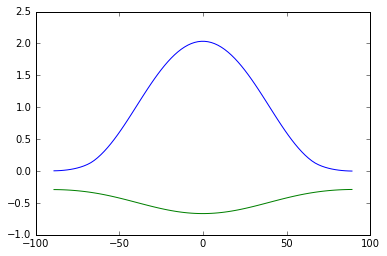

In [49]:
#  Reduced evaporation gives equatorially enhanced warming of surface
#  and cooling of near-surface air temperature
plt.plot(diffebm.lat, diffebm3.Ts - diffebm.Ts)
plt.plot(diffebm.lat, diffebm3.Tatm[:,0] - diffebm.Tatm[:,0])

Pretty much the same result.

## Some stuff with Band models

In [50]:
#  Put in some ozone
import netCDF4 as nc

datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/Brian+Rose/CESM+runs/"
endstr = "/entry.das"

topo = nc.Dataset( datapath + 'som_input/USGS-gtopo30_1.9x2.5_remap_c050602.nc' + endstr )
ozone = nc.Dataset( datapath + 'som_input/ozone_1.9x2.5_L26_2000clim_c091112.nc' + endstr )

#  Dimensions of the ozone file
lat = ozone.variables['lat'][:]
lon = ozone.variables['lon'][:]
lev = ozone.variables['lev'][:]

# Taking annual, zonal average of the ozone data
O3_zon = np.mean( ozone.variables['O3'],axis=(0,3) )

In [51]:
#  make a model on the same grid as the ozone
model1 = climlab.BandRCModel(lev=lev, lat=lat)
insolation = climlab.radiation.insolation.AnnualMeanInsolation(domains=model1.Ts.domain)
model1.add_subprocess('insolation', insolation)
print model1

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (96, 26) 
  Ts: (96, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>



In [52]:
#  Set the ozone mixing ratio
#   IMPORTANT: we need to flip the ozone array around because the vertical coordinate runs the wrong way
#   (first element is top of atmosphere, whereas our model expects the first element to be just above the surface)
O3_trans = np.transpose(O3_zon)
O3_flipped = np.fliplr(O3_trans)
# Put in the ozone
model1.absorber_vmr['O3'] = O3_flipped

In [53]:
model1.param

{'Q': 341.3,
 'abs_coeff': 0.0001229,
 'adj_lapse_rate': 6.5,
 'albedo_sfc': 0.299,
 'timestep': 86400.0,
 'water_depth': 1.0}

In [54]:
#  Convective adjustment for atmosphere only
model1.remove_subprocess('convective adjustment')
conv = climlab.convection.convadj.ConvectiveAdjustment(state={'Tatm':model1.state['Tatm']}, **model1.param)
model1.add_subprocess('convective adjustment', conv)

In [55]:
#  Add surface heat fluxes
from climlab.surface.turbulent import SensibleHeatFlux, LatentHeatFlux
shf = SensibleHeatFlux(state=model1.state, Cd=0.5E-3)
lhf = LatentHeatFlux(state=model1.state, Cd=0.5E-3)
#  set the water vapor input field for LHF process
lhf.q = model1.q
model1.add_subprocess('SHF', shf)
model1.add_subprocess('LHF', lhf)

In [56]:
model1.step_forward()

In [57]:
model1.integrate_years(1.)

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 1.00207478763 years.


In [58]:
model1.integrate_years(1.)

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 2.00141166601 years.


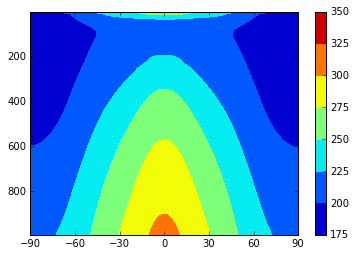

In [59]:
plot_temp_section(model1, timeave=False)

In [60]:
co2model1 = climlab.process_like(model1)
co2model1.absorber_vmr['CO2'] *= 2

In [61]:
co2model1.integrate_years(3.)

Integrating for 1095 steps, 1095.7266 days, or 3.0 years.
Total elapsed time is 4.99942230115 years.


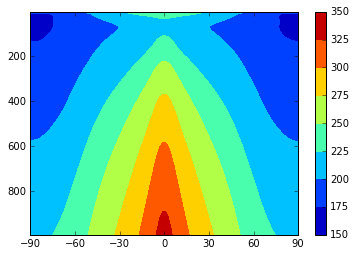

In [62]:
plot_temp_section(co2model1, timeave=False)

Model gets very very hot near equator. Very large equator-to-pole gradient.

## Band model with heat transport and evaporation

In [63]:
diffmodel1 = climlab.process_like(model1)
# thermal diffusivity in W/m**2/degC
D = 0.01
# meridional diffusivity in 1/s
K = D / diffmodel1.Tatm.domain.heat_capacity[0]
d = climlab.dynamics.diffusion.MeridionalDiffusion(K=K, state={'Tatm': diffmodel1.state['Tatm']}, **diffmodel1.param)
diffmodel1.add_subprocess('diffusion', d)
diffmodel1.absorber_vmr['CO2'] *= 4.
print diffmodel1

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (96, 26) 
  Ts: (96, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   diffusion: <class 'climlab.dynamics.diffusion.MeridionalDiffusion'>
   LHF: <class 'climlab.surface.turbulent.LatentHeatFlux'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>



Integrating for 1095 steps, 1095.7266 days, or 3.0 years.
Total elapsed time is 4.99942230115 years.


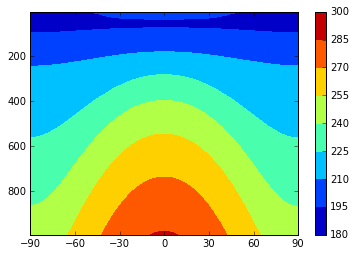

In [64]:
diffmodel1.integrate_years(3.)
plot_temp_section(diffmodel1, timeave=False)

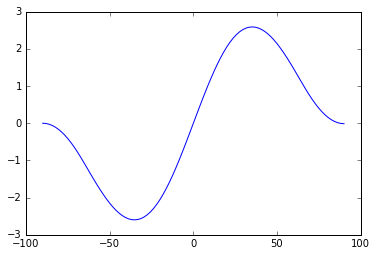

In [65]:
Rtoa = np.squeeze(diffmodel1.timeave['ASR'] - diffmodel1.timeave['OLR'])
#Rtoa_co2 = np.squeeze(co2diffmodel1.timeave['ASR'] - co2diffmodel1.timeave['OLR'])
plt.plot(diffmodel1.lat, inferred_heat_transport(Rtoa, diffmodel1.lat))
#plt.plot(diffmodel1.lat, inferred_heat_transport(Rtoa_co2, diffmodel1.lat))

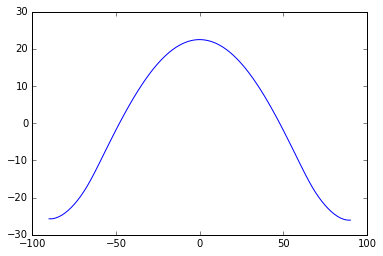

In [66]:
plt.plot(diffmodel1.lat, diffmodel1.Ts-273.15)

In [67]:
#  Now double CO2
co2diffmodel1 = climlab.process_like(diffmodel1)
co2diffmodel1.absorber_vmr['CO2'] *= 2.
co2diffmodel1.integrate_years(5)

Integrating for 1826 steps, 1826.211 days, or 5 years.
Total elapsed time is 9.99884460229 years.


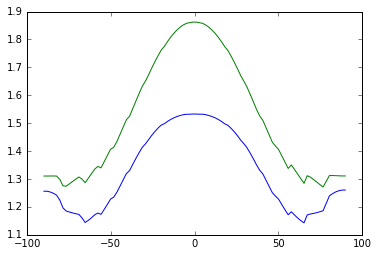

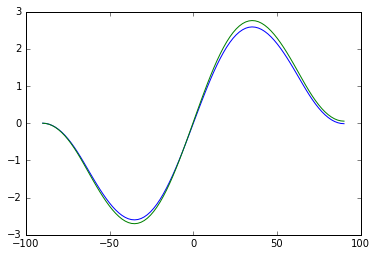

In [68]:
#  No polar amplification in this model!
plt.plot(diffmodel1.lat, co2diffmodel1.Ts - diffmodel1.Ts)
plt.plot(diffmodel1.lat, co2diffmodel1.Tatm[:,0] - diffmodel1.Tatm[:,0])
plt.figure()
Rtoa = np.squeeze(diffmodel1.timeave['ASR'] - diffmodel1.timeave['OLR'])
Rtoa_co2 = np.squeeze(co2diffmodel1.timeave['ASR'] - co2diffmodel1.timeave['OLR'])
plt.plot(diffmodel1.lat, inferred_heat_transport(Rtoa, diffmodel1.lat))
plt.plot(diffmodel1.lat, inferred_heat_transport(Rtoa_co2, diffmodel1.lat))